In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [13]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [14]:
df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


## Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

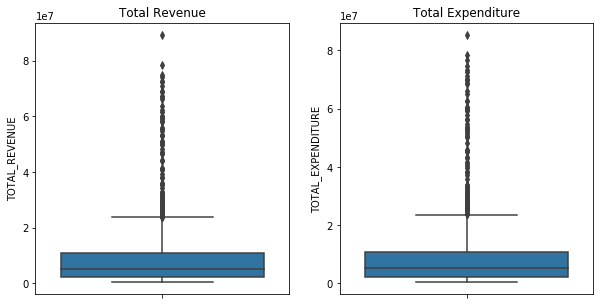

In [15]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(y=df['TOTAL_REVENUE'])
plt.title('Total Revenue')

plt.subplot(1,2,2)
sns.boxplot(y=df['TOTAL_EXPENDITURE'])
plt.title('Total Expenditure')

plt.show()

There appears to be many outliers based on the boxplots. I will use Tukeys method with a threshold of 1.5 to get the exact number of outliers. First I must address all the missing values in all columns

In [25]:
cols_to_fill = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G", "TOTAL_DEFICIT"]

In [17]:
def outlier_count(columns, dataframe):
    for col in cols_to_fill:
        if col in (columns):
            columns_in_cols_to_fill += 1
            q25, q75 = np.nanpercentile(dataframe[col], [25, 75])
            iqr = q75 - q25
            threshold = 1.5
            min_val = q25 - (threshold*iqr)
            max_val = q75 + (threshold*iqr)
            outlier_count = 0
            for num in dataframe[col]:
                if (num < min_val) or (num > max_val):
                    outlier_count += 1
            print('Total number of outliers for {}: {}'.format(col, outlier_count))
outlier_count(['TOTAL_REVENUE', 'TOTAL_EXPENDITURE'], df)

Total number of outliers for TOTAL_REVENUE: 110
Total number of outliers for TOTAL_EXPENDITURE: 111


In [18]:
states = df["STATE"].unique()

for state in states:
    df.loc[df["STATE"] == state, cols_to_fill] = df.loc[df["STATE"] == state, cols_to_fill].interpolate()

# we drop the null values after interpolation
df.dropna(inplace=True)

In [19]:
outlier_count(['TOTAL_REVENUE', 'TOTAL_EXPENDITURE'], df)

Total number of outliers for TOTAL_REVENUE: 45
Total number of outliers for TOTAL_EXPENDITURE: 46


## If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

In [20]:
from scipy.stats.mstats import winsorize

windsorized1 = df.copy()
windsorized1.loc[:, 'TOTAL_REVENUE'] = winsorize(windsorized1['TOTAL_REVENUE'], (0,.10))
windsorized1.loc[:, 'TOTAL_EXPENDITURE'] = winsorize(windsorized1['TOTAL_EXPENDITURE'], (0,.10))

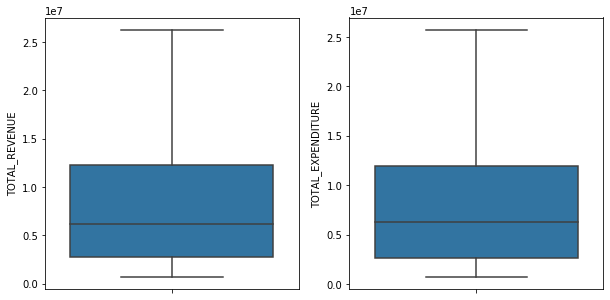

In [21]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(y=windsorized1['TOTAL_REVENUE'])

plt.subplot(1,2,2)
sns.boxplot(y=windsorized1['TOTAL_EXPENDITURE'])

plt.show()

In [22]:
outlier_count(['TOTAL_REVENUE', 'TOTAL_EXPENDITURE'], windsorized1)

Total number of outliers for TOTAL_REVENUE: 0
Total number of outliers for TOTAL_EXPENDITURE: 0


## Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [26]:
df['TOTAL_DEFICIT'] = df['TOTAL_REVENUE'] - df['TOTAL_EXPENDITURE']

outlier_count(['TOTAL_DEFICIT'], df)

Total number of outliers for TOTAL_DEFICIT: 64


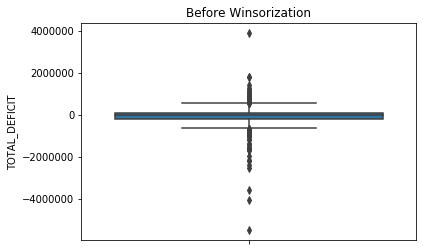

In [56]:
sns.boxplot(y = df['TOTAL_DEFICIT'])
plt.title('Before Winsorization')
plt.show()

In [55]:
windsorized2 = df.copy()
windsorized2.loc[:, 'TOTAL_DEFICIT'] = winsorize(windsorized2['TOTAL_DEFICIT'], (.10,.10))

In [54]:
outlier_count(['TOTAL_DEFICIT'], windsorized2)

Total number of outliers for TOTAL_DEFICIT: 0


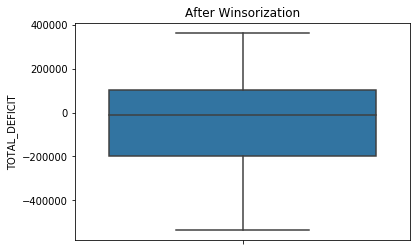

In [57]:
sns.boxplot(y = windsorized2['TOTAL_DEFICIT'])
plt.title('After Winsorization')
plt.show()

## Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

In [58]:
windsorized1['TOTAL_DEFICIT'] = windsorized1['TOTAL_REVENUE'] - windsorized1['TOTAL_EXPENDITURE']

outlier_count(['TOTAL_DEFICIT'], windsorized1)

Total number of outliers for TOTAL_DEFICIT: 34


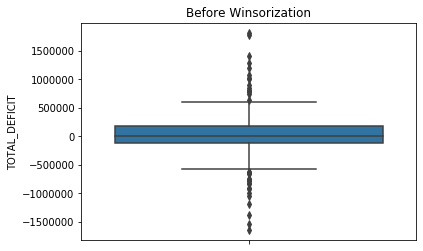

In [59]:
sns.boxplot(y = windsorized1['TOTAL_DEFICIT'])
plt.title('Before Winsorization')
plt.show()

In [60]:
windsorized3 = windsorized1.copy()
windsorized3.loc[:, 'TOTAL_DEFICIT'] = winsorize(windsorized3['TOTAL_DEFICIT'], (.10,.10))

In [61]:
outlier_count(['TOTAL_DEFICIT'], windsorized3)

Total number of outliers for TOTAL_DEFICIT: 0


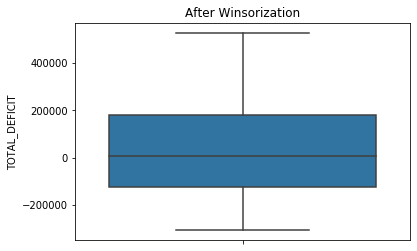

In [63]:
sns.boxplot(y = windsorized3['TOTAL_DEFICIT'])
plt.title('After Winsorization')
plt.show()

## Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

In [62]:
comparison = pd.DataFrame()
comparison['TOTAL_DEFICIT_QUESTION_3'] = windsorized2['TOTAL_DEFICIT'].describe()
comparison['TOTAL_DEFICIT_QUESTION_4'] = windsorized3['TOTAL_DEFICIT'].describe()
comparison

,TOTAL_DEFICIT_QUESTION_3,TOTAL_DEFICIT_QUESTION_4
count,466.000000,466.000000
mean,-46221.075107,58068.461373
std,256023.510074,261701.775745
min,-538253.000000,-306362.000000
25%,-196574.750000,-123882.250000
50%,-8872.500000,8133.500000
75%,101394.750000,180287.250000
max,365079.000000,526078.000000


There are significant differences between means, standard deviations, and ranges.

## If our variable of interest is the budget deficit variable, which method do you think is the most appropriate one in dealing with the outliers in this variable. The method in the third question or the one in the fourth question?

I believe the method in question 3 is more appropriate. Eliminating the outliers before and after the transformation creates more bias than eliminating outliers only after the transformation.